# Определение стоимости автомобилей

**Описание проекта**  

Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Построим модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.  

Критерии, которые важны заказчику:  
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Описание данных**

Данные находятся в файле `autos.csv`.

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

*Целевой признак*
- Price — цена (евро)

**Импорты**

In [1]:
# Установка пакетов 

!pip install missingno -q
!pip install phik -q
!pip install catboost -q
!pip install --upgrade scikit-learn -q
!pip install tqdm -q
!pip install wordcloud -q

In [2]:
# Импорты стандартных библиотек

import os
import time

# Импорты сторонних библиотек

import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud

import catboost
import lightgbm
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from lightgbm import LGBMRegressor
import phik
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

## Загрузка и знакомство с данными

In [3]:
pth1 = 'C:/Users/.../autos.csv'
pth2 = 'https://code.s3.yandex.net/datasets/autos.csv'
pth3 = '/datasets/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
elif os.path.exists(pth3):
    df = pd.read_csv(pth3)
else:
    print('Something is wrong')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# Создадим функцию для приведения названия полей к нормативному стилю:

def convert_case_columns(title):
    for symb in title:
        if symb.isupper():
            title = title.replace(symb, '_' + symb.lower())
    title = title[1:]
    return title

In [6]:
# Переименуем столбцы:

new_column_names = [convert_case_columns(col) for col in df.columns.tolist()]
df.columns = new_column_names

# Проверим результат:

df.columns.tolist()

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

Данные в полях date_crawled, date_created и last_seen необходимо привести к типу `date`.

In [7]:
# Применяем:

to_date_list = ['date_crawled', 'date_created', 'last_seen']

for item in to_date_list:
    df[item] = pd.to_datetime(df[item])

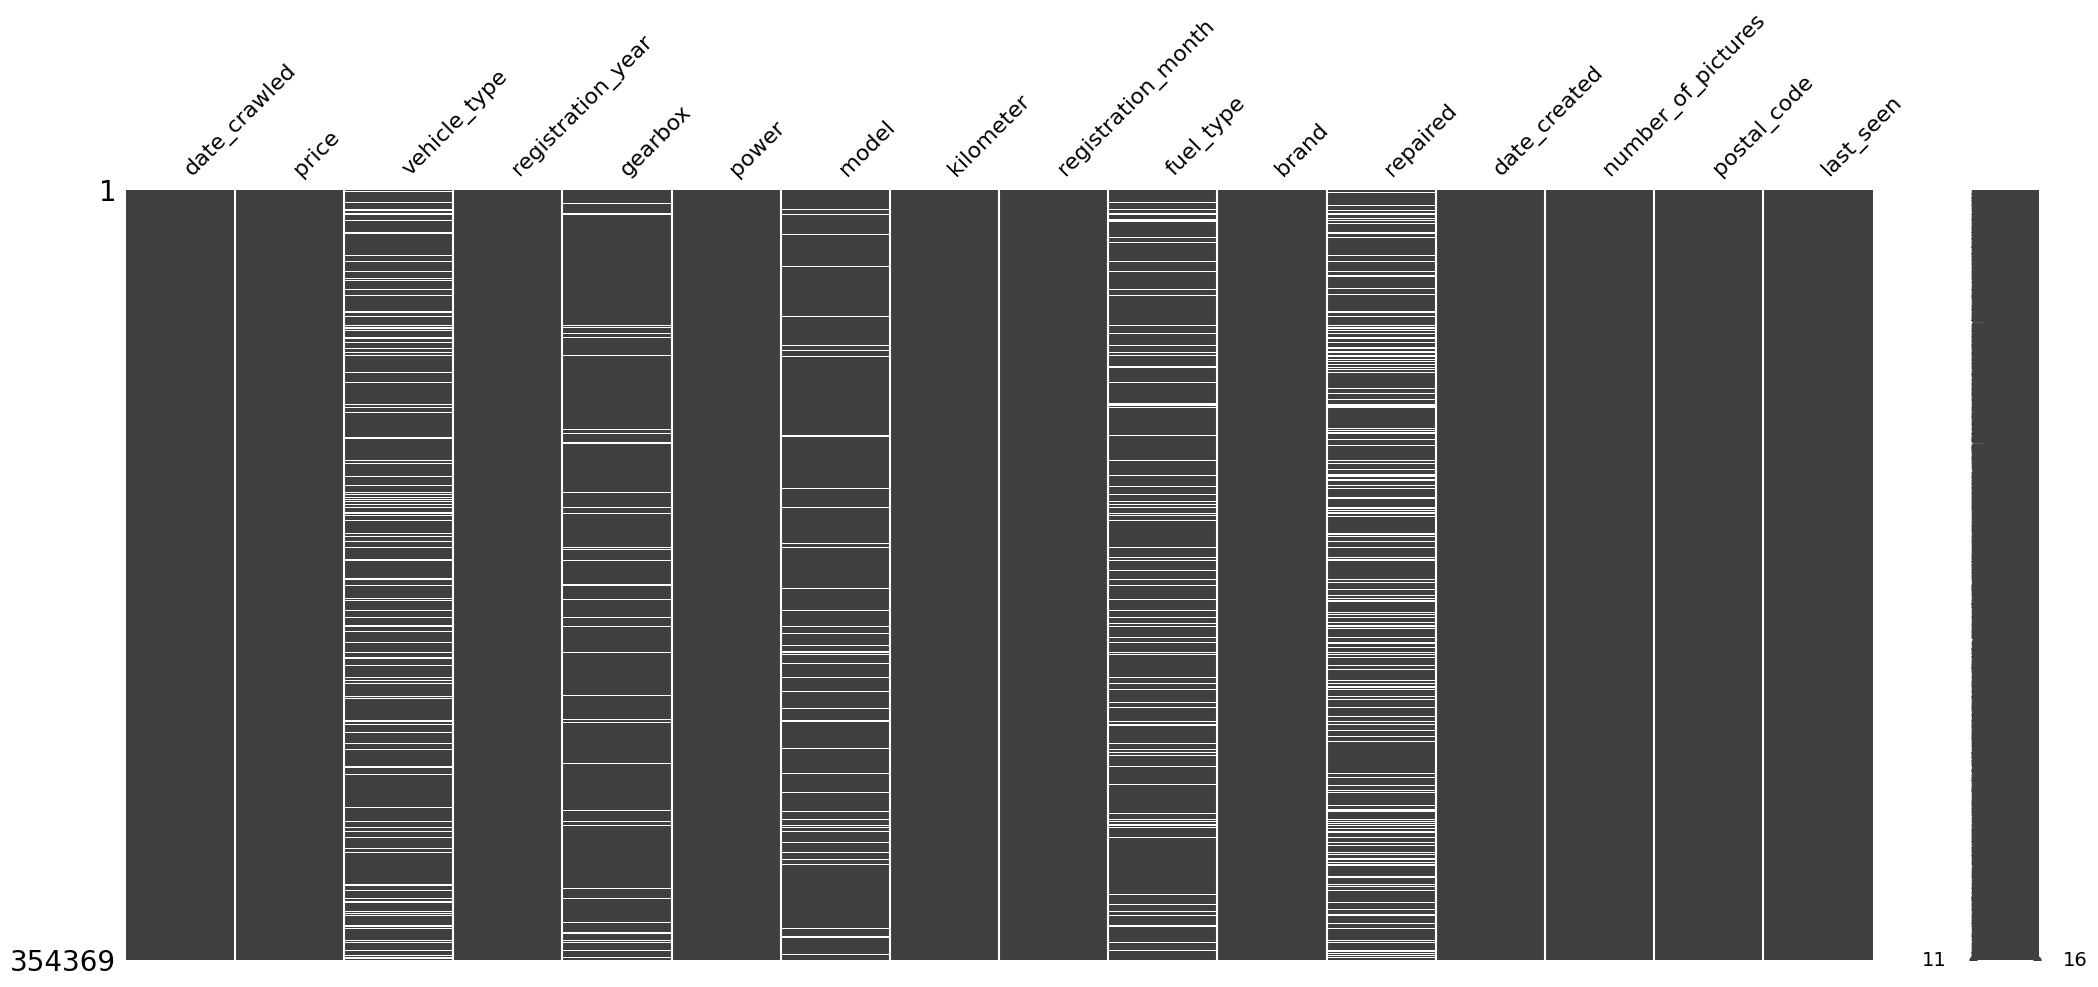

In [8]:
# визуализируем пропущенные значения:

msno.matrix(df);

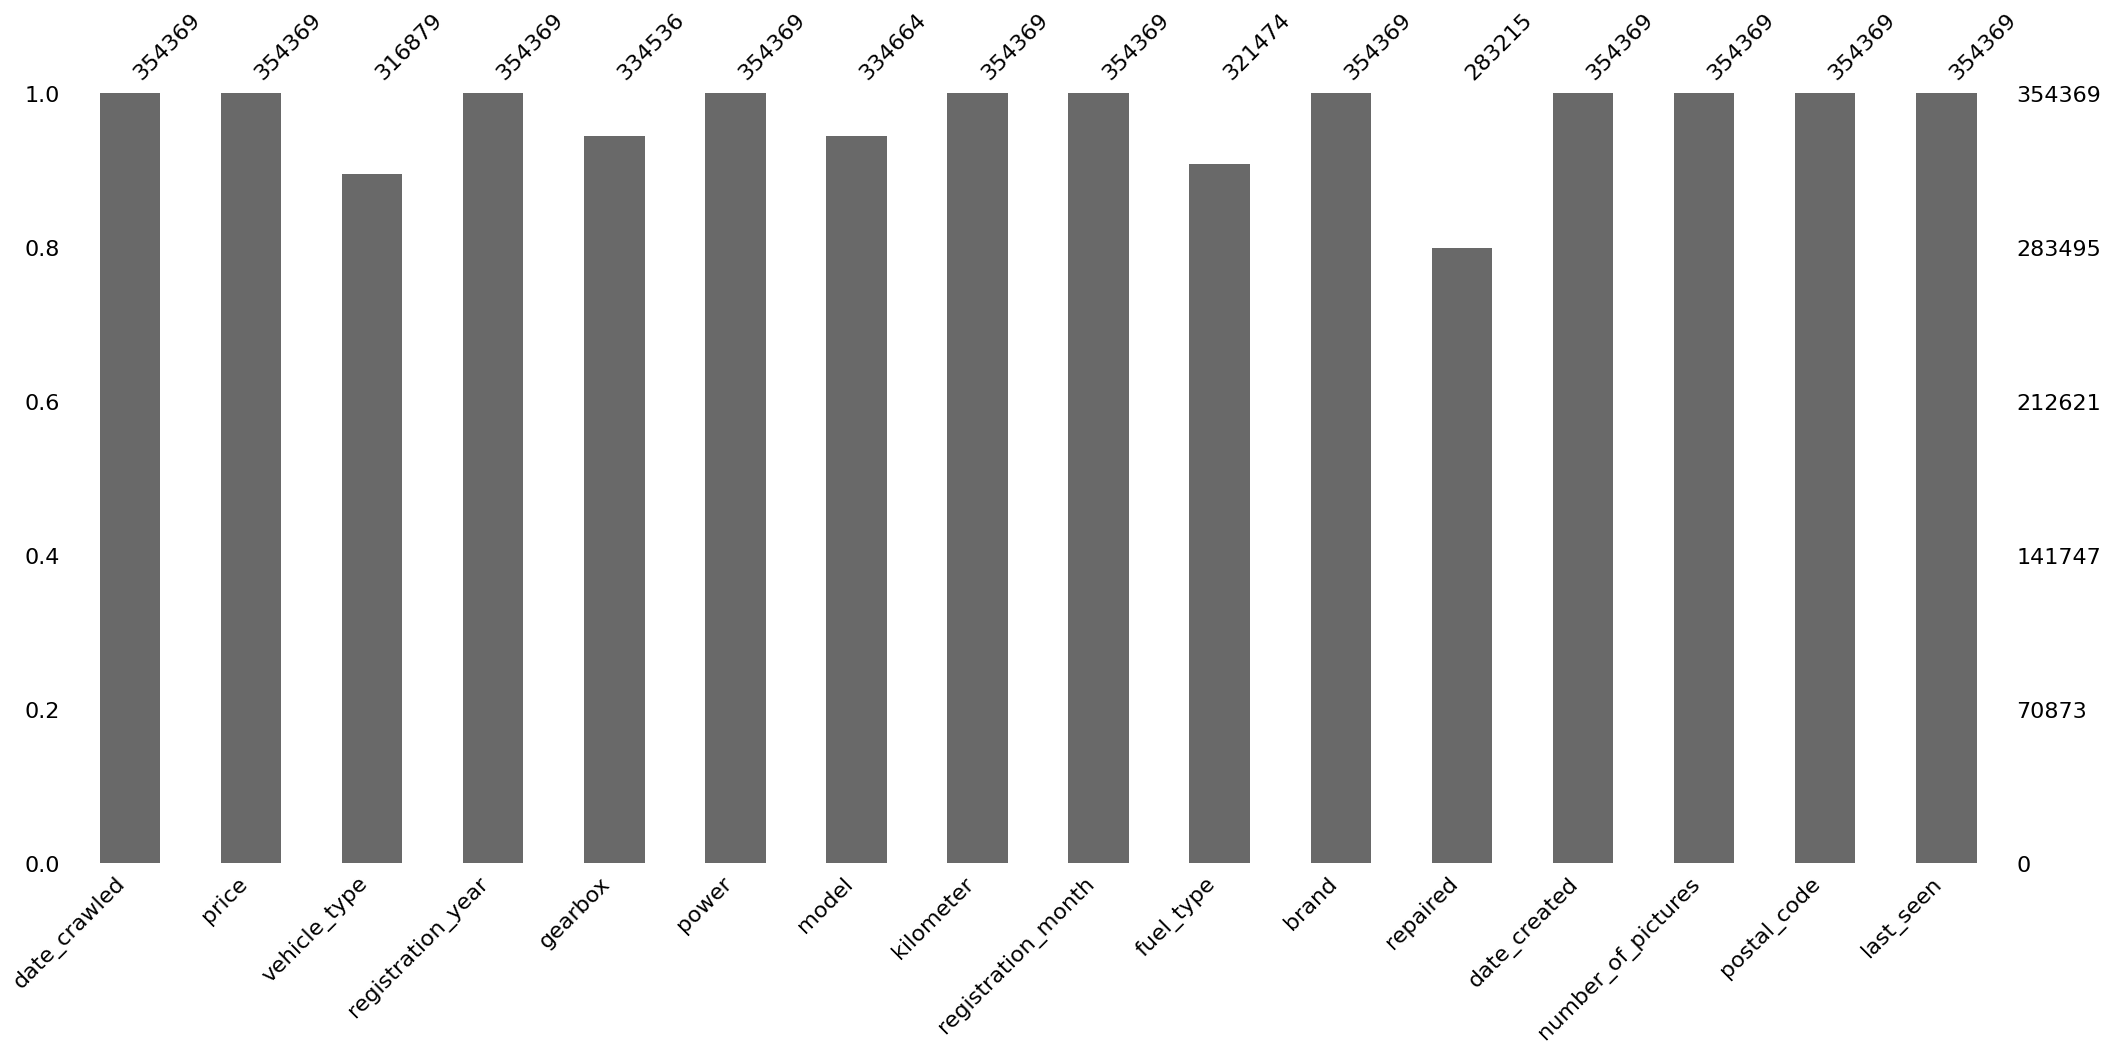

In [9]:
msno.bar(df);

Доля отсутствующих значений для некоторых (5 из 16) признаков составляет от 5 до 20% от размера датасета.  
Распределение пропусков относительно равномерное.

In [10]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Минимальные значения некоторых признаков равны нулю. Рассмотрим их подробнее далее.  
Поле number_of_pictures содержит нулевые значения для всех записей, оно неинформативно и подлежит удалению.

In [11]:
df = df.drop('number_of_pictures', axis=1)
df.shape

(354369, 15)

Визуализируем распределение числовых значений.

In [12]:
def visual_num_val(value):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Гистограмма
    ax1.hist(df[value[0]], bins=50, edgecolor='black')
    ax1.set_title(f'График распрелеления значений {value[0]}')
    ax1.set_xlabel(value[1])
    ax1.set_ylabel(value[2])

    # Диаграмма размаха
    ax2.boxplot(df[value[0]], vert=False)
    ax2.set_title(f'Диаграмма размаха для {value[0]}')
    ax2.set_xlabel(value[1])

    plt.tight_layout()
    plt.show()

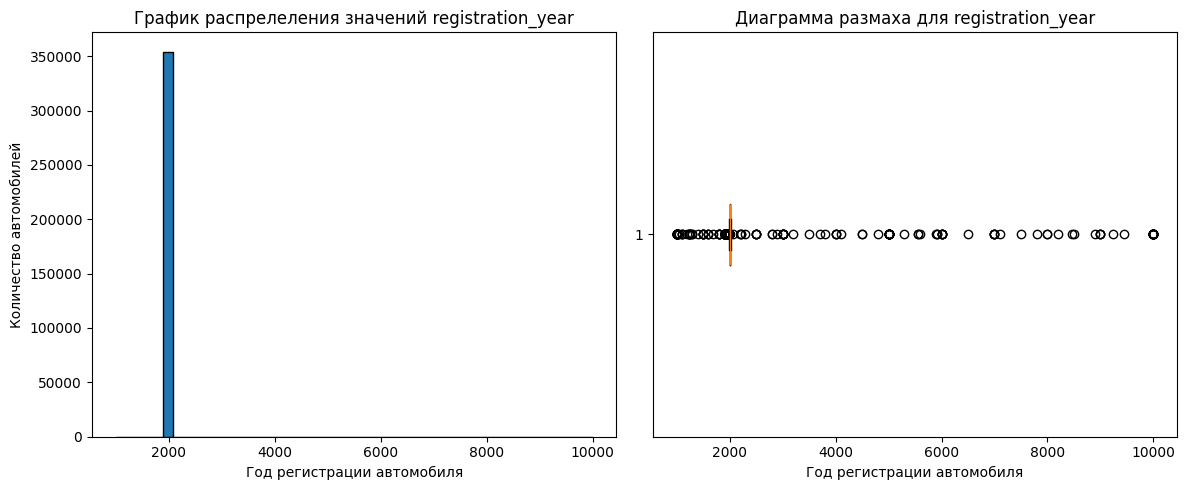

In [13]:
registration_year = ['registration_year', # Title
                     'Год регистрации автомобиля', # Xlabel
                     'Количество автомобилей' # Ylabel
                    ] 
visual_num_val(registration_year)

In [14]:
df['registration_year'].quantile([0.01, 0.98])

0.01    1980.0
0.98    2017.0
Name: registration_year, dtype: float64

In [15]:
df = df.loc[df['registration_year']<=2016]

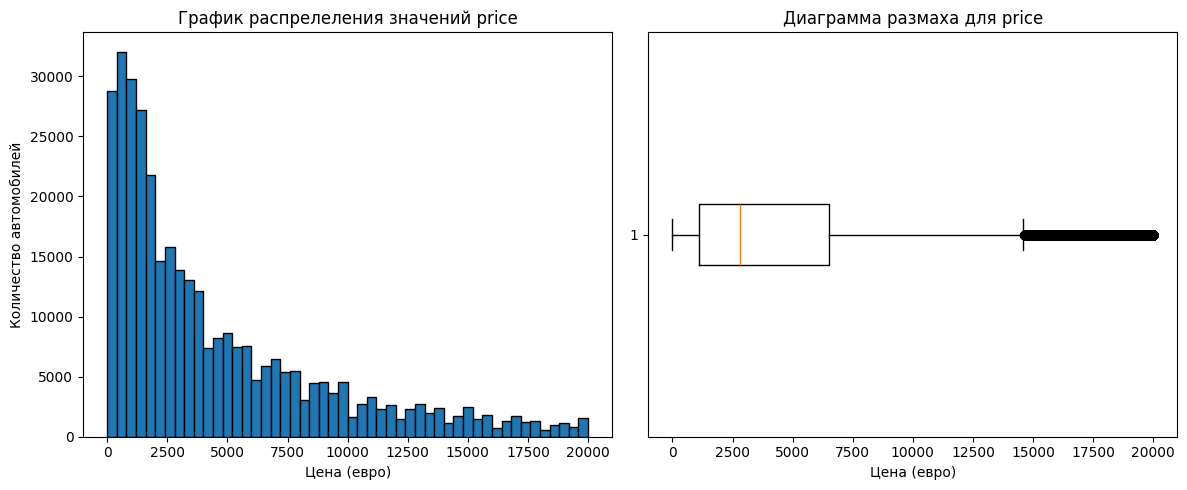

In [16]:
price = ['price',
        'Цена (евро)',
        'Количество автомобилей'
        ]
visual_num_val(price)

In [17]:
df['price'].quantile([0.05, 0.95])

0.05      200.0
0.95    14800.0
Name: price, dtype: float64

In [18]:
df = df.query('200 < price < 14600')

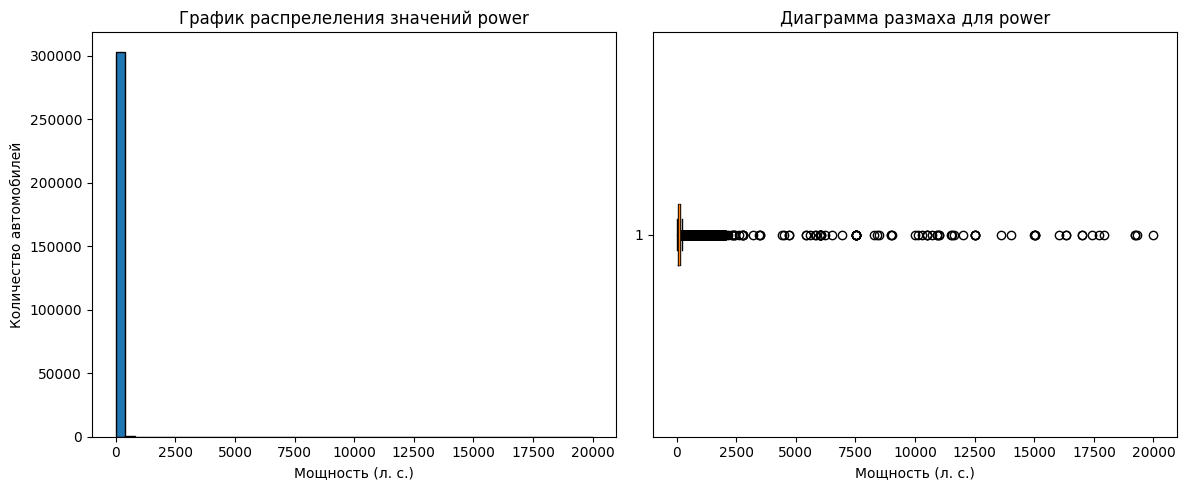

In [19]:
power = ['power',
        'Мощность (л. с.)',
        'Количество автомобилей'
        ]
visual_num_val(power)

In [20]:
df['power'].quantile([0.11, 0.98])

0.11     45.0
0.98    239.0
Name: power, dtype: float64

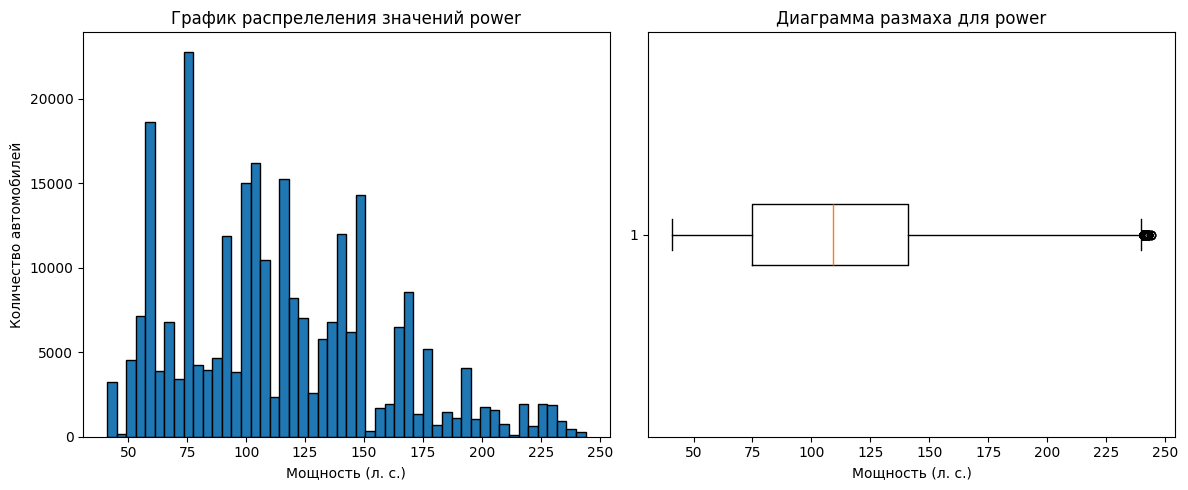

In [21]:
df = df.query('40 < power < 245')

# Обновляем переменную 'power' с новыми данными
power = ('power', 'Мощность (л. с.)', 'Количество автомобилей')

# Вызываем функцию для визуализации
visual_num_val(power)

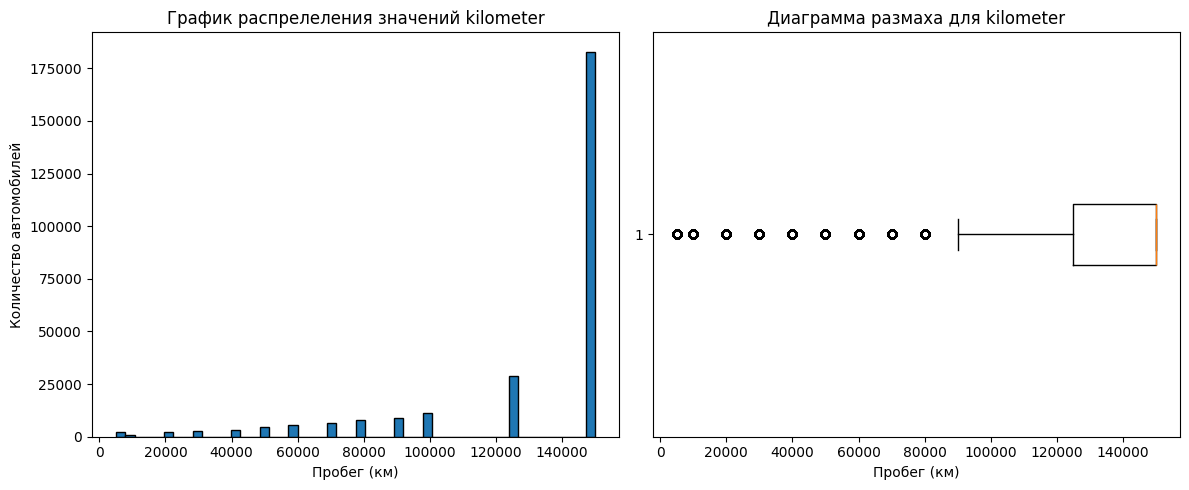

In [22]:
kilometer = ('kilometer',
             'Пробег (км)',
             'Количество автомобилей')

visual_num_val(kilometer)

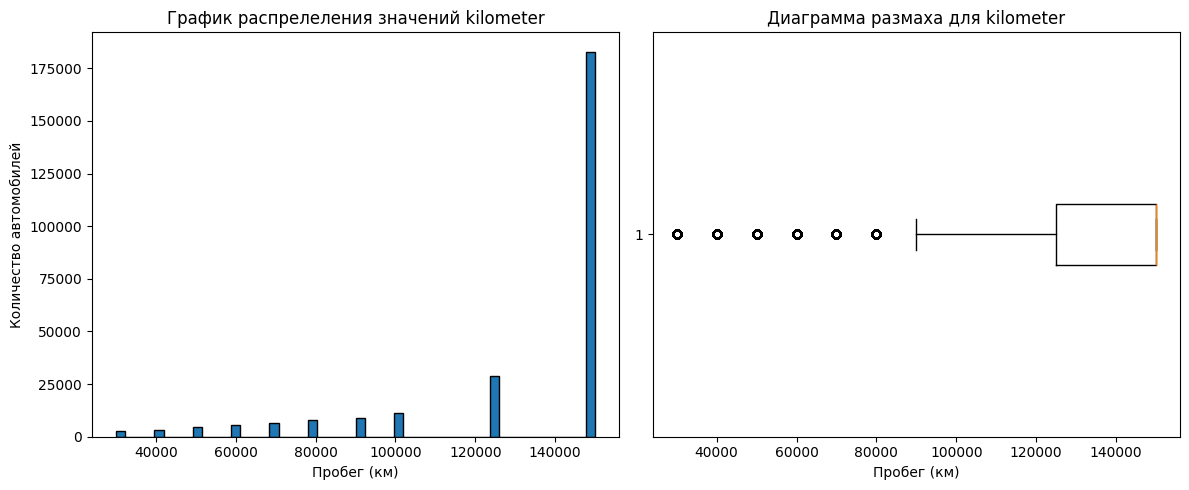

In [23]:
df = df.query('kilometer > 20000')

visual_num_val(kilometer)

Проверка на неявные дубликаты категориальных переменных:

In [24]:
cat_list = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# Произведем визуальный поиск неявных дубликатов / опечаток / пропусков:

for item in cat_list:
    print('\n',df[item].unique())


 ['suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' nan 'coupe' 'other']

 ['auto' 'manual' nan]

 ['grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat' 'polo'
 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other' 'civic' 'punto'
 'e_klasse' 'clio' 'kadett' 'one' 'fortwo' '1er' 'b_klasse' 'a8' 'jetta'
 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' nan 'escort'
 'forester' 'xc_reihe' 'scenic' 'ka' 'a1' 'transporter' 'focus' 'a4' 'tt'
 'astra' 'a6' 'jazz' 'omega' 'slk' 'combo' 'corsa' '80' '147' 'z_reihe'
 'ibiza' 'eos' 'touran' 'getz' 'insignia' 'almera' 'megane' 'a3' 'lupo'
 'r19' 'caddy' 'mondeo' 'cordoba' 'colt' 'impreza' 'vectra' 'berlingo'
 '7er' 'tiguan' 'c4' 'panda' 'up' 'i_reihe' 'ceed' 'kangoo' 'yeti'
 'octavia' 'zafira' 'mii' 'rx_reihe' 'modus' 'fox' 'matiz' 'beetle' 'rio'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'c3' '1_reihe' 'sharan' 'avensis'
 'viano' 'roomster' 'sl' 'kaefer' '6_reihe' 'santa' 'cooper' '4_reihe'
 'sportage' 'laguna' 'ptcruiser' 'clk' 'pri

В основном, начения выглядят уникальными, есть пропуски.  
У признака `fuel_type` `petrol` и `gasoline` дублируют друг друга. Оставим одно значение `petrol`.

In [25]:
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')

*Тип автомобильного кузова*

In [26]:
df.query('vehicle_type.isna()')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,38871,2016-04-01 12:46:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08,19386,2016-03-08 09:44:50
71,2016-03-07 08:55:18,2300,NaN,1997,manual,150,5er,150000,3,NaN,bmw,no,2016-03-07,79341,2016-03-22 05:15:22
77,2016-03-31 22:48:06,800,NaN,2000,manual,90,golf,150000,2,petrol,volkswagen,NaN,2016-03-31,32584,2016-04-06 19:15:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354100,2016-03-12 09:56:23,600,NaN,2016,manual,170,vectra,150000,0,petrol,opel,yes,2016-03-12,67475,2016-04-06 01:46:52
354107,2016-03-09 12:51:50,395,NaN,2016,manual,60,golf,150000,12,petrol,volkswagen,NaN,2016-03-09,25575,2016-04-05 23:45:21
354115,2016-03-07 11:59:24,299,NaN,2016,manual,60,astra,150000,4,petrol,opel,yes,2016-03-07,49326,2016-03-20 01:46:49
354351,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11,87700,2016-03-12 14:16:51


In [27]:
# Создадим список уникальных значений 'Brand' (в поле 'Brand' пропуски отсутствуют)

brand_list = df['brand'].unique()

for element in tqdm(brand_list):
    
    # Отфильтруем DataFrame по текущей марке
    df_brand = df.loc[df['brand'] == element]
    
    # Определим наиболее часто встречающийся тип автомобильного кузова для текущей марки
    most_common_type = df_brand['vehicle_type'].value_counts().idxmax()
    
    # Выведем текущую марку и наиболее часто встречающийся тип кузова
    print(element, ' - ', most_common_type)
    
    # Заполним пропущенные значения 'vehicle_type' для текущей марки
    df.loc[(df['brand'] == element) & (pd.isna(df['vehicle_type'])), 'vehicle_type'] = most_common_type


  0%|          | 0/40 [00:00<?, ?it/s]

jeep  -  suv
volkswagen  -  sedan


  8%|▊         | 3/40 [00:00<00:01, 24.24it/s]

skoda  -  wagon
bmw  -  sedan
peugeot  -  small


 15%|█▌        | 6/40 [00:00<00:01, 22.06it/s]

ford  -  small
mazda  -  sedan
renault  -  small


 22%|██▎       | 9/40 [00:00<00:01, 24.56it/s]

mercedes_benz  -  sedan
seat  -  small
honda  -  sedan


 30%|███       | 12/40 [00:00<00:01, 24.96it/s]

fiat  -  small
opel  -  small
mini  -  small


 38%|███▊      | 15/40 [00:00<00:01, 24.22it/s]

smart  -  small
audi  -  wagon
nissan  -  small


 45%|████▌     | 18/40 [00:00<00:00, 25.51it/s]

alfa_romeo  -  sedan
subaru  -  wagon
volvo  -  wagon
mitsubishi  -  sedan


 52%|█████▎    | 21/40 [00:00<00:00, 25.80it/s]

hyundai  -  small
suzuki  -  small


 60%|██████    | 24/40 [00:00<00:00, 26.78it/s]

lancia  -  small
citroen  -  small
toyota  -  small


 68%|██████▊   | 27/40 [00:01<00:00, 24.31it/s]

kia  -  small
chevrolet  -  small


 75%|███████▌  | 30/40 [00:01<00:00, 24.14it/s]

dacia  -  wagon
daihatsu  -  small
chrysler  -  bus
sonstige_autos  -  sedan


 82%|████████▎ | 33/40 [00:01<00:00, 23.96it/s]

jaguar  -  sedan


 90%|█████████ | 36/40 [00:01<00:00, 25.12it/s]

daewoo  -  small
rover  -  sedan
porsche  -  convertible
saab  -  sedan
land_rover  -  suv


 98%|█████████▊| 39/40 [00:01<00:00, 25.57it/s]

trabant  -  sedan


100%|██████████| 40/40 [00:01<00:00, 25.06it/s]

lada  -  suv


In [28]:
df['vehicle_type'].isna().sum()

0

*Модель автомобиля*

In [29]:
df['model'].isna().sum()

9211

In [30]:
# Рассмотрим информацию о модели автомобиля 'model' для бренда 'brand' под обозначением sonstige_autos (другие автомобили):

display(df.loc[df['brand'] == 'sonstige_autos'])
print(df.loc[df['brand'] == 'sonstige_autos']['model'].unique())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
700,2016-03-30 21:37:21,6999,sedan,2010,auto,186,NaN,125000,4,petrol,sonstige_autos,no,2016-03-30,81929,2016-04-05 11:18:33
985,2016-03-15 16:37:22,500,sedan,2010,manual,101,NaN,70000,1,petrol,sonstige_autos,yes,2016-03-15,76829,2016-03-21 14:15:21
1098,2016-03-06 22:43:51,11500,bus,1985,auto,160,NaN,125000,10,petrol,sonstige_autos,NaN,2016-03-06,4849,2016-04-05 18:17:04
1405,2016-03-28 15:37:13,3999,convertible,1999,manual,120,NaN,125000,9,petrol,sonstige_autos,no,2016-03-28,16567,2016-04-06 20:15:37
2499,2016-04-04 20:36:25,6500,convertible,1983,manual,106,NaN,70000,2,petrol,sonstige_autos,NaN,2016-04-04,94118,2016-04-06 22:46:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353756,2016-04-01 16:53:46,250,small,1997,manual,66,NaN,150000,5,petrol,sonstige_autos,NaN,2016-04-01,7548,2016-04-05 12:17:30
353867,2016-03-29 00:38:48,5000,sedan,2006,manual,175,NaN,125000,12,petrol,sonstige_autos,no,2016-03-28,71397,2016-04-05 14:16:37
353892,2016-03-06 11:42:12,7900,bus,2009,NaN,140,NaN,125000,7,petrol,sonstige_autos,no,2016-03-06,97256,2016-03-26 16:16:02
354062,2016-03-19 11:25:16,6000,small,2008,manual,155,NaN,150000,5,petrol,sonstige_autos,no,2016-03-19,63069,2016-04-07 00:46:42


[nan]


Информация о модели авто для бренда "другие автомобили" отсутствует. Заполним поле значением 'no_info':

In [31]:
df.loc[df['brand'] == 'sonstige_autos', 'model'] = 'no_info'

print(df.loc[df['brand'] == 'sonstige_autos']['model'].value_counts())

no_info    1037
Name: model, dtype: int64


In [32]:
# Заполним остальные пропуски в поле модели автомобиля по наиболее часто встречающемуся значению для бренда

for element in tqdm(brand_list):
    
    # Отфильтруем DataFrame по текущей марке
    df_brand = df.loc[df['brand'] == element]
    
    # Определим наиболее часто встречающееся значение 'model' для бренда авто:
    most_common_type = df_brand['model'].value_counts().idxmax()
    
    # Выведем текущий бренд и наиболее часто встречающееся значение 'model':
    print(element, ' - ', most_common_type)
    
    # Заполним пропущенные значения 'model' для текущей марки:
    df.loc[(df['brand'] == element) & (pd.isna(df['model'])), 'model'] = most_common_type

  0%|          | 0/40 [00:00<?, ?it/s]

jeep  -  grand


  8%|▊         | 3/40 [00:00<00:01, 27.08it/s]

volkswagen  -  golf
skoda  -  fabia
bmw  -  3er
peugeot  -  2_reihe
ford  -  focus


 15%|█▌        | 6/40 [00:00<00:01, 21.17it/s]

mazda  -  6_reihe
renault  -  twingo
mercedes_benz  -  c_klasse


 22%|██▎       | 9/40 [00:00<00:01, 21.29it/s]

seat  -  ibiza
honda  -  civic
fiat  -  punto


 30%|███       | 12/40 [00:00<00:01, 22.78it/s]

opel  -  corsa
mini  -  cooper
smart  -  fortwo


 38%|███▊      | 15/40 [00:00<00:01, 23.49it/s]

audi  -  a4
nissan  -  micra
alfa_romeo  -  156


 45%|████▌     | 18/40 [00:00<00:00, 22.27it/s]

subaru  -  impreza
volvo  -  v40


 52%|█████▎    | 21/40 [00:00<00:00, 23.57it/s]

mitsubishi  -  colt
hyundai  -  i_reihe
suzuki  -  other
lancia  -  ypsilon


 60%|██████    | 24/40 [00:01<00:00, 23.89it/s]

citroen  -  other
toyota  -  yaris
kia  -  other


 75%|███████▌  | 30/40 [00:01<00:00, 26.22it/s]

chevrolet  -  other
dacia  -  logan
daihatsu  -  cuore


 82%|████████▎ | 33/40 [00:01<00:00, 26.96it/s]

chrysler  -  other
sonstige_autos  -  no_info
jaguar  -  x_type
daewoo  -  matiz
rover  -  other
porsche  -  other


 98%|█████████▊| 39/40 [00:01<00:00, 26.23it/s]

saab  -  other
land_rover  -  freelander
trabant  -  other


100%|██████████| 40/40 [00:01<00:00, 24.60it/s]

lada  -  niva


In [33]:
# Проверка на наличие пропущенных значений для признака

df['model'].isna().sum()

0

*Тип коробки передач*

In [34]:
print(df['gearbox'].isna().sum())
print(df['gearbox'].value_counts())

4610
manual    211983
auto       45784
Name: gearbox, dtype: int64


In [35]:
# Список уникальных значений 'brand' и 'model'

brand_list = df['brand'].unique()
model_list = df['model'].unique()

for brand in tqdm(brand_list):
    for model in model_list:
        
        # Отфильтруем DataFrame по текущей марке и модели
        df_filtered = df[(df['brand'] == brand) & (df['model'] == model)]

        # Если есть данные для этой комбинации бренда и модели
        if not df_filtered.empty:
            
            # Определим наиболее часто встречающееся значение типа коробки передач для данной марки и модели
            most_common_gearbox = df_filtered['gearbox'].value_counts().idxmax()
            
            # Выведем текущий бренд, модель и наиболее часто встречающееся значение типа коробки передач
            print(f"{brand} - {model}: {most_common_gearbox}")
            
            # Заполним пропущенные значения 'gearbox' для текущей комбинации марки и модели
            df.loc[(df['brand'] == brand) & (df['model'] == model) & (pd.isna(df['gearbox'])), 'gearbox'] = most_common_gearbox


  0%|          | 0/40 [00:00<?, ?it/s]

jeep - grand: auto
jeep - other: manual
jeep - wrangler: manual
jeep - cherokee: auto


  2%|▎         | 1/40 [00:06<04:09,  6.39s/it]

volkswagen - golf: manual
volkswagen - passat: manual
volkswagen - polo: manual
volkswagen - scirocco: manual
volkswagen - other: manual
volkswagen - jetta: manual
volkswagen - transporter: manual
volkswagen - eos: manual
volkswagen - touran: manual
volkswagen - lupo: manual
volkswagen - caddy: manual
volkswagen - tiguan: manual
volkswagen - up: manual
volkswagen - fox: manual
volkswagen - beetle: manual
volkswagen - sharan: manual
volkswagen - kaefer: manual
volkswagen - phaeton: auto
volkswagen - touareg: auto
volkswagen - bora: manual
volkswagen - cc: manual


  5%|▌         | 2/40 [00:13<04:21,  6.88s/it]

volkswagen - amarok: manual
skoda - fabia: manual
skoda - other: manual
skoda - yeti: manual
skoda - octavia: manual
skoda - roomster: manual
skoda - superb: manual
skoda - citigo: manual


  8%|▊         | 3/40 [00:20<04:13,  6.86s/it]

bmw - 3er: manual
bmw - 5er: auto
bmw - other: manual
bmw - 1er: manual
bmw - z_reihe: manual
bmw - 7er: auto
bmw - x_reihe: auto
bmw - 6er: manual
bmw - m_reihe: manual
bmw - i3: manual


 10%|█         | 4/40 [00:27<04:09,  6.94s/it]

peugeot - 2_reihe: manual
peugeot - 3_reihe: manual
peugeot - other: manual
peugeot - 1_reihe: manual
peugeot - 4_reihe: manual
peugeot - 5_reihe: manual


 12%|█▎        | 5/40 [00:34<04:06,  7.04s/it]

ford - c_max: manual
ford - other: manual
ford - fiesta: manual
ford - escort: manual
ford - ka: manual
ford - focus: manual
ford - mondeo: manual
ford - s_max: manual
ford - galaxy: manual
ford - fusion: manual
ford - transit: manual
ford - kuga: manual
ford - b_max: manual
ford - mustang: auto


 15%|█▌        | 6/40 [00:42<04:06,  7.24s/it]

mazda - 3_reihe: manual
mazda - other: manual
mazda - rx_reihe: manual
mazda - 1_reihe: manual
mazda - 6_reihe: manual
mazda - mx_reihe: manual
mazda - 5_reihe: manual
mazda - cx_reihe: manual


 18%|█▊        | 7/40 [00:48<03:51,  7.02s/it]

renault - twingo: manual
renault - other: manual
renault - clio: manual
renault - scenic: manual
renault - megane: manual
renault - r19: manual
renault - kangoo: manual
renault - modus: manual
renault - laguna: manual
renault - espace: manual


 20%|██        | 8/40 [00:55<03:39,  6.84s/it]

mercedes_benz - a_klasse: manual
mercedes_benz - other: manual
mercedes_benz - e_klasse: auto
mercedes_benz - b_klasse: manual
mercedes_benz - c_klasse: manual
mercedes_benz - vito: manual
mercedes_benz - sprinter: manual
mercedes_benz - slk: manual
mercedes_benz - viano: auto
mercedes_benz - sl: auto
mercedes_benz - clk: auto
mercedes_benz - s_klasse: auto
mercedes_benz - v_klasse: auto
mercedes_benz - cl: manual
mercedes_benz - m_klasse: auto
mercedes_benz - g_klasse: manual
mercedes_benz - glk: auto


 22%|██▎       | 9/40 [01:02<03:32,  6.87s/it]

mercedes_benz - gl: auto
seat - arosa: manual
seat - other: manual
seat - ibiza: manual
seat - cordoba: manual
seat - mii: manual
seat - alhambra: manual
seat - leon: manual
seat - toledo: manual
seat - altea: manual
seat - exeo: manual


 25%|██▌       | 10/40 [01:08<03:23,  6.78s/it]

honda - other: manual
honda - civic: manual
honda - jazz: manual
honda - accord: manual
honda - cr_reihe: manual


 28%|██▊       | 11/40 [01:15<03:13,  6.66s/it]

fiat - other: manual
fiat - punto: manual
fiat - panda: manual
fiat - stilo: manual
fiat - 500: manual
fiat - ducato: manual
fiat - bravo: manual
fiat - seicento: manual
fiat - croma: manual
fiat - doblo: manual


 30%|███       | 12/40 [01:21<03:06,  6.66s/it]

opel - other: manual
opel - kadett: manual
opel - astra: manual
opel - omega: manual
opel - combo: manual
opel - corsa: manual
opel - insignia: manual
opel - vectra: manual
opel - zafira: manual
opel - signum: manual
opel - agila: manual
opel - meriva: manual
opel - tigra: manual
opel - antara: manual
opel - vivaro: manual
opel - calibra: manual


 32%|███▎      | 13/40 [01:28<03:02,  6.77s/it]

mini - other: manual
mini - one: manual
mini - cooper: manual
mini - clubman: manual


 35%|███▌      | 14/40 [01:35<02:54,  6.70s/it]

smart - other: auto
smart - fortwo: auto
smart - roadster: auto
smart - forfour: manual


 38%|███▊      | 15/40 [01:41<02:43,  6.55s/it]

audi - other: manual
audi - a8: auto
audi - a1: manual
audi - a4: manual
audi - tt: manual
audi - a6: auto
audi - 80: manual
audi - a3: manual
audi - a2: manual
audi - 90: manual
audi - a5: auto
audi - 100: manual
audi - q7: auto
audi - 200: manual
audi - q5: auto


 40%|████      | 16/40 [01:48<02:40,  6.69s/it]

audi - q3: manual
nissan - other: manual
nissan - micra: manual
nissan - almera: manual
nissan - primera: manual
nissan - juke: manual
nissan - x_trail: manual
nissan - qashqai: manual
nissan - note: manual
nissan - navara: manual


 42%|████▎     | 17/40 [01:55<02:31,  6.60s/it]

alfa_romeo - other: manual
alfa_romeo - 156: manual
alfa_romeo - 147: manual
alfa_romeo - spider: manual
alfa_romeo - 159: manual
alfa_romeo - 145: manual


 45%|████▌     | 18/40 [02:01<02:23,  6.54s/it]

subaru - other: manual
subaru - forester: manual
subaru - impreza: manual
subaru - justy: manual
subaru - legacy: manual


 48%|████▊     | 19/40 [02:07<02:16,  6.50s/it]

volvo - other: manual
volvo - xc_reihe: auto
volvo - v40: manual
volvo - v50: manual
volvo - c_reihe: manual
volvo - v70: manual
volvo - s60: manual
volvo - 850: manual
volvo - v60: manual


 50%|█████     | 20/40 [02:14<02:11,  6.56s/it]

mitsubishi - other: manual
mitsubishi - colt: manual
mitsubishi - carisma: manual
mitsubishi - galant: manual
mitsubishi - lancer: manual
mitsubishi - pajero: manual
mitsubishi - outlander: manual


 52%|█████▎    | 21/40 [02:21<02:05,  6.58s/it]

hyundai - other: manual
hyundai - getz: manual
hyundai - i_reihe: manual
hyundai - santa: manual
hyundai - tucson: manual


 55%|█████▌    | 22/40 [02:27<01:57,  6.52s/it]

suzuki - grand: manual
suzuki - other: manual
suzuki - swift: manual
suzuki - jimny: manual


 57%|█████▊    | 23/40 [02:33<01:49,  6.45s/it]

lancia - other: manual
lancia - ypsilon: manual
lancia - lybra: manual
lancia - musa: manual
lancia - delta: manual
lancia - elefantino: manual


 60%|██████    | 24/40 [02:40<01:44,  6.53s/it]

lancia - kappa: manual
citroen - other: manual
citroen - berlingo: manual
citroen - c4: manual
citroen - c3: manual
citroen - c5: manual
citroen - c1: manual
citroen - c2: manual


 62%|██████▎   | 25/40 [02:47<01:38,  6.54s/it]

toyota - other: manual
toyota - avensis: manual
toyota - corolla: manual
toyota - verso: manual
toyota - rav: manual
toyota - yaris: manual
toyota - aygo: manual
toyota - auris: manual


 65%|██████▌   | 26/40 [02:54<01:34,  6.73s/it]

kia - other: manual
kia - ceed: manual
kia - rio: manual
kia - sportage: manual
kia - picanto: manual
kia - sorento: auto
kia - carnival: manual


 68%|██████▊   | 27/40 [03:01<01:28,  6.80s/it]

chevrolet - other: manual
chevrolet - matiz: manual
chevrolet - spark: manual
chevrolet - captiva: manual
chevrolet - aveo: manual


 70%|███████   | 28/40 [03:07<01:20,  6.73s/it]

dacia - other: manual
dacia - logan: manual
dacia - duster: manual
dacia - sandero: manual
dacia - lodgy: manual


 72%|███████▎  | 29/40 [03:15<01:15,  6.85s/it]

daihatsu - other: manual
daihatsu - cuore: manual
daihatsu - sirion: manual
daihatsu - charade: manual
daihatsu - move: manual
daihatsu - materia: manual
daihatsu - terios: manual


 75%|███████▌  | 30/40 [03:21<01:08,  6.86s/it]

chrysler - grand: auto
chrysler - other: auto
chrysler - ptcruiser: manual
chrysler - crossfire: auto
chrysler - 300c: auto
chrysler - voyager: manual


 78%|███████▊  | 31/40 [03:29<01:02,  6.94s/it]

sonstige_autos - no_info: manual


 80%|████████  | 32/40 [03:35<00:54,  6.81s/it]

jaguar - other: auto
jaguar - s_type: auto
jaguar - x_type: manual


 82%|████████▎ | 33/40 [03:42<00:47,  6.76s/it]

daewoo - other: manual
daewoo - matiz: manual
daewoo - lanos: manual
daewoo - nubira: manual
daewoo - kalos: manual


 85%|████████▌ | 34/40 [03:48<00:40,  6.73s/it]

rover - other: manual
rover - discovery: manual
rover - freelander: auto
rover - defender: manual
rover - rangerover: manual


 88%|████████▊ | 35/40 [03:55<00:33,  6.72s/it]

porsche - other: manual
porsche - boxster: manual


 90%|█████████ | 36/40 [04:02<00:26,  6.70s/it]

porsche - 911: manual
saab - other: manual
saab - 900: manual
saab - 9000: manual


 92%|█████████▎| 37/40 [04:09<00:20,  6.74s/it]

land_rover - other: manual
land_rover - discovery: auto
land_rover - freelander: manual
land_rover - defender: manual
land_rover - serie_2: manual
land_rover - range_rover_sport: auto
land_rover - range_rover: auto


 95%|█████████▌| 38/40 [04:16<00:13,  6.82s/it]

land_rover - serie_3: manual
trabant - other: manual


 98%|█████████▊| 39/40 [04:22<00:06,  6.74s/it]

trabant - 601: manual
lada - other: manual
lada - niva: manual
lada - kalina: manual
lada - samara: manual


100%|██████████| 40/40 [04:29<00:00,  6.74s/it]


In [36]:
# Проверка на наличие пропущенных значений для признака

df['gearbox'].isna().sum()

0

*Тип топлива*

In [37]:
# Аналогично предыдущему шагу

for brand in tqdm(brand_list):
    for model in model_list:
        
        # Отфильтруем DataFrame по текущей марке и модели
        df_filtered = df[(df['brand'] == brand) & (df['model'] == model)]

        # Если есть данные для этой комбинации бренда и модели
        if not df_filtered.empty:
            
            # Определим наиболее часто встречающееся значение типа топлива для данной марки и модели
            most_common_fuel_type = df_filtered['fuel_type'].value_counts().idxmax()
            
            # Выведем текущий бренд, модель и наиболее часто встречающееся значение типа топлива
            print(f"{brand} - {model}: {most_common_fuel_type}")
            
            # Заполним пропущенные значения 'fuel_type' для текущей комбинации марки и модели
            df.loc[(df['brand'] == brand) & (df['model'] == model) & (pd.isna(df['fuel_type'])),
                   'fuel_type'] = most_common_fuel_type

  0%|          | 0/40 [00:00<?, ?it/s]

jeep - grand: petrol
jeep - other: petrol
jeep - wrangler: petrol
jeep - cherokee: petrol


  2%|▎         | 1/40 [00:06<04:26,  6.82s/it]

volkswagen - golf: petrol
volkswagen - passat: petrol
volkswagen - polo: petrol
volkswagen - scirocco: petrol
volkswagen - other: petrol
volkswagen - jetta: petrol
volkswagen - transporter: petrol
volkswagen - eos: petrol
volkswagen - touran: petrol
volkswagen - lupo: petrol
volkswagen - caddy: petrol
volkswagen - tiguan: petrol
volkswagen - up: petrol
volkswagen - fox: petrol
volkswagen - beetle: petrol
volkswagen - sharan: petrol
volkswagen - kaefer: petrol
volkswagen - phaeton: petrol
volkswagen - touareg: petrol
volkswagen - bora: petrol
volkswagen - cc: petrol


  5%|▌         | 2/40 [00:14<04:33,  7.20s/it]

volkswagen - amarok: petrol
skoda - fabia: petrol
skoda - other: petrol
skoda - yeti: petrol
skoda - octavia: petrol
skoda - roomster: petrol
skoda - superb: petrol
skoda - citigo: petrol


  8%|▊         | 3/40 [00:21<04:19,  7.02s/it]

bmw - 3er: petrol
bmw - 5er: petrol
bmw - other: petrol
bmw - 1er: petrol
bmw - z_reihe: petrol
bmw - 7er: petrol
bmw - x_reihe: petrol
bmw - 6er: petrol
bmw - m_reihe: petrol
bmw - i3: petrol


 10%|█         | 4/40 [00:28<04:11,  6.98s/it]

peugeot - 2_reihe: petrol
peugeot - 3_reihe: petrol
peugeot - other: petrol
peugeot - 1_reihe: petrol
peugeot - 4_reihe: petrol
peugeot - 5_reihe: petrol


 12%|█▎        | 5/40 [00:34<04:02,  6.93s/it]

ford - c_max: petrol
ford - other: petrol
ford - fiesta: petrol
ford - escort: petrol
ford - ka: petrol
ford - focus: petrol
ford - mondeo: petrol
ford - s_max: petrol
ford - galaxy: petrol
ford - fusion: petrol
ford - transit: petrol
ford - kuga: petrol
ford - b_max: petrol
ford - mustang: petrol


 15%|█▌        | 6/40 [00:42<03:59,  7.04s/it]

mazda - 3_reihe: petrol
mazda - other: petrol
mazda - rx_reihe: petrol
mazda - 1_reihe: petrol
mazda - 6_reihe: petrol
mazda - mx_reihe: petrol
mazda - 5_reihe: petrol
mazda - cx_reihe: petrol


 18%|█▊        | 7/40 [00:49<03:51,  7.00s/it]

renault - twingo: petrol
renault - other: petrol
renault - clio: petrol
renault - scenic: petrol
renault - megane: petrol
renault - r19: petrol
renault - kangoo: petrol
renault - modus: petrol
renault - laguna: petrol
renault - espace: petrol


 20%|██        | 8/40 [00:55<03:43,  6.98s/it]

mercedes_benz - a_klasse: petrol
mercedes_benz - other: petrol
mercedes_benz - e_klasse: petrol
mercedes_benz - b_klasse: petrol
mercedes_benz - c_klasse: petrol
mercedes_benz - vito: petrol
mercedes_benz - sprinter: petrol
mercedes_benz - slk: petrol
mercedes_benz - viano: petrol
mercedes_benz - sl: petrol
mercedes_benz - clk: petrol
mercedes_benz - s_klasse: petrol
mercedes_benz - v_klasse: petrol
mercedes_benz - cl: petrol
mercedes_benz - m_klasse: petrol
mercedes_benz - g_klasse: petrol
mercedes_benz - glk: petrol


 22%|██▎       | 9/40 [01:03<03:39,  7.09s/it]

mercedes_benz - gl: petrol
seat - arosa: petrol
seat - other: petrol
seat - ibiza: petrol
seat - cordoba: petrol
seat - mii: petrol
seat - alhambra: petrol
seat - leon: petrol
seat - toledo: petrol
seat - altea: petrol
seat - exeo: petrol


 25%|██▌       | 10/40 [01:10<03:32,  7.09s/it]

honda - other: petrol
honda - civic: petrol
honda - jazz: petrol
honda - accord: petrol
honda - cr_reihe: petrol


 28%|██▊       | 11/40 [01:17<03:23,  7.02s/it]

fiat - other: petrol
fiat - punto: petrol
fiat - panda: petrol
fiat - stilo: petrol
fiat - 500: petrol
fiat - ducato: petrol
fiat - bravo: petrol
fiat - seicento: petrol
fiat - croma: petrol
fiat - doblo: petrol


 30%|███       | 12/40 [01:24<03:17,  7.04s/it]

opel - other: petrol
opel - kadett: petrol
opel - astra: petrol
opel - omega: petrol
opel - combo: petrol
opel - corsa: petrol
opel - insignia: petrol
opel - vectra: petrol
opel - zafira: petrol
opel - signum: petrol
opel - agila: petrol
opel - meriva: petrol
opel - tigra: petrol
opel - antara: petrol
opel - vivaro: petrol
opel - calibra: petrol


 32%|███▎      | 13/40 [01:31<03:12,  7.14s/it]

mini - other: petrol
mini - one: petrol
mini - cooper: petrol
mini - clubman: petrol


 35%|███▌      | 14/40 [01:38<03:03,  7.05s/it]

smart - other: petrol
smart - fortwo: petrol
smart - roadster: petrol
smart - forfour: petrol


 38%|███▊      | 15/40 [01:45<02:53,  6.94s/it]

audi - other: petrol
audi - a8: petrol
audi - a1: petrol
audi - a4: petrol
audi - tt: petrol
audi - a6: petrol
audi - 80: petrol
audi - a3: petrol
audi - a2: petrol
audi - 90: petrol
audi - a5: petrol
audi - 100: petrol
audi - q7: petrol
audi - 200: petrol
audi - q5: petrol


 40%|████      | 16/40 [01:52<02:49,  7.07s/it]

audi - q3: petrol
nissan - other: petrol
nissan - micra: petrol
nissan - almera: petrol
nissan - primera: petrol
nissan - juke: petrol
nissan - x_trail: petrol
nissan - qashqai: petrol
nissan - note: petrol
nissan - navara: petrol


 42%|████▎     | 17/40 [01:59<02:41,  7.00s/it]

alfa_romeo - other: petrol
alfa_romeo - 156: petrol
alfa_romeo - 147: petrol
alfa_romeo - spider: petrol
alfa_romeo - 159: petrol
alfa_romeo - 145: petrol


 45%|████▌     | 18/40 [02:06<02:33,  6.96s/it]

subaru - other: petrol
subaru - forester: petrol
subaru - impreza: petrol
subaru - justy: petrol
subaru - legacy: petrol


 48%|████▊     | 19/40 [02:13<02:24,  6.88s/it]

volvo - other: petrol
volvo - xc_reihe: petrol
volvo - v40: petrol
volvo - v50: petrol
volvo - c_reihe: petrol
volvo - v70: petrol
volvo - s60: petrol
volvo - 850: petrol
volvo - v60: petrol


 50%|█████     | 20/40 [02:20<02:18,  6.94s/it]

mitsubishi - other: petrol
mitsubishi - colt: petrol
mitsubishi - carisma: petrol
mitsubishi - galant: petrol
mitsubishi - lancer: petrol
mitsubishi - pajero: petrol
mitsubishi - outlander: petrol


 52%|█████▎    | 21/40 [02:27<02:12,  6.96s/it]

hyundai - other: petrol
hyundai - getz: petrol
hyundai - i_reihe: petrol
hyundai - santa: petrol
hyundai - tucson: petrol


 55%|█████▌    | 22/40 [02:33<02:04,  6.93s/it]

suzuki - grand: petrol
suzuki - other: petrol
suzuki - swift: petrol
suzuki - jimny: petrol


 57%|█████▊    | 23/40 [02:41<01:58,  6.99s/it]

lancia - other: petrol
lancia - ypsilon: petrol
lancia - lybra: petrol
lancia - musa: petrol
lancia - delta: petrol
lancia - elefantino: petrol


 60%|██████    | 24/40 [02:48<01:52,  7.05s/it]

lancia - kappa: petrol
citroen - other: petrol
citroen - berlingo: petrol
citroen - c4: petrol
citroen - c3: petrol
citroen - c5: petrol
citroen - c1: petrol
citroen - c2: petrol


 62%|██████▎   | 25/40 [02:56<01:48,  7.25s/it]

toyota - other: petrol
toyota - avensis: petrol
toyota - corolla: petrol
toyota - verso: petrol
toyota - rav: petrol
toyota - yaris: petrol
toyota - aygo: petrol
toyota - auris: petrol


 65%|██████▌   | 26/40 [03:03<01:40,  7.20s/it]

kia - other: petrol
kia - ceed: petrol
kia - rio: petrol
kia - sportage: petrol
kia - picanto: petrol
kia - sorento: petrol
kia - carnival: petrol


 68%|██████▊   | 27/40 [03:10<01:33,  7.16s/it]

chevrolet - other: petrol
chevrolet - matiz: petrol
chevrolet - spark: petrol
chevrolet - captiva: petrol
chevrolet - aveo: petrol


 70%|███████   | 28/40 [03:16<01:24,  7.00s/it]

dacia - other: petrol
dacia - logan: petrol
dacia - duster: petrol
dacia - sandero: petrol
dacia - lodgy: petrol


 72%|███████▎  | 29/40 [03:23<01:16,  6.92s/it]

daihatsu - other: petrol
daihatsu - cuore: petrol
daihatsu - sirion: petrol
daihatsu - charade: petrol
daihatsu - move: petrol
daihatsu - materia: petrol
daihatsu - terios: petrol


 75%|███████▌  | 30/40 [03:30<01:08,  6.89s/it]

chrysler - grand: petrol
chrysler - other: petrol
chrysler - ptcruiser: petrol
chrysler - crossfire: petrol
chrysler - 300c: petrol
chrysler - voyager: petrol


 78%|███████▊  | 31/40 [03:37<01:01,  6.83s/it]

sonstige_autos - no_info: petrol


 80%|████████  | 32/40 [03:43<00:54,  6.81s/it]

jaguar - other: petrol
jaguar - s_type: petrol
jaguar - x_type: petrol


 82%|████████▎ | 33/40 [03:50<00:47,  6.79s/it]

daewoo - other: petrol
daewoo - matiz: petrol
daewoo - lanos: petrol
daewoo - nubira: petrol
daewoo - kalos: petrol


 85%|████████▌ | 34/40 [03:57<00:41,  6.84s/it]

rover - other: petrol
rover - discovery: petrol
rover - freelander: petrol
rover - defender: petrol
rover - rangerover: petrol


 88%|████████▊ | 35/40 [04:04<00:34,  6.87s/it]

porsche - other: petrol
porsche - boxster: petrol


 90%|█████████ | 36/40 [04:11<00:27,  6.89s/it]

porsche - 911: petrol
saab - other: petrol
saab - 900: petrol
saab - 9000: petrol


 92%|█████████▎| 37/40 [04:18<00:20,  6.87s/it]

land_rover - other: petrol
land_rover - discovery: petrol
land_rover - freelander: petrol
land_rover - defender: petrol
land_rover - serie_2: petrol
land_rover - range_rover_sport: petrol
land_rover - range_rover: petrol


 95%|█████████▌| 38/40 [04:24<00:13,  6.77s/it]

land_rover - serie_3: petrol
trabant - other: petrol


 98%|█████████▊| 39/40 [04:31<00:06,  6.76s/it]

trabant - 601: petrol
lada - other: petrol
lada - niva: petrol
lada - kalina: petrol
lada - samara: petrol


100%|██████████| 40/40 [04:38<00:00,  6.95s/it]


*Информация о том, была ли машина в ремонте или нет*

In [38]:
print('Nan', df['repaired'].isna().sum())
print(df['repaired'].value_counts())

Nan 38002
no     198857
yes     25518
Name: repaired, dtype: int64


In [39]:
# В данном случае пропуски уместно заменить на значение 'no_info'

df['repaired'] = df['repaired'].fillna('no_info')

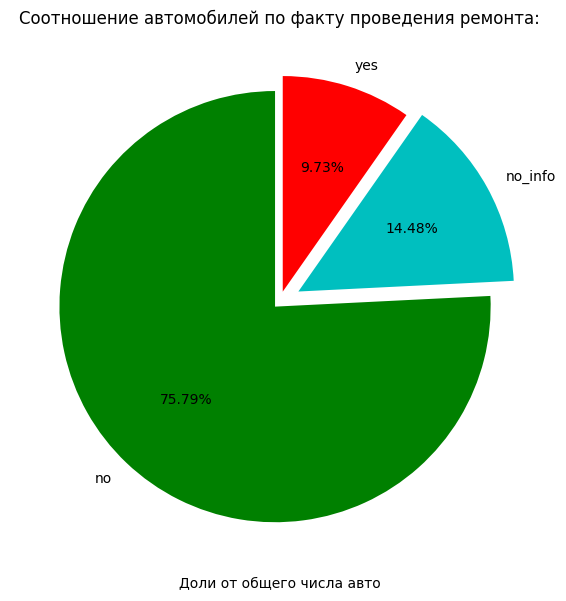

In [40]:
# Визуализируем распределение значений при помощи круговой диаграммы

fig = plt.figure(figsize=(7,7))
ax = df['repaired'].value_counts().plot(kind="pie",
                                        colors=['g', 'c', 'r'], 
                                        autopct='%1.2f%%',
                                        explode = [0.03,0.1,0.05],
                                        startangle=90,
                                        );
ax.set(xlabel='Доли от общего числа авто',
       ylabel='',
       title='Соотношение автомобилей по факту проведения ремонта:'
      );

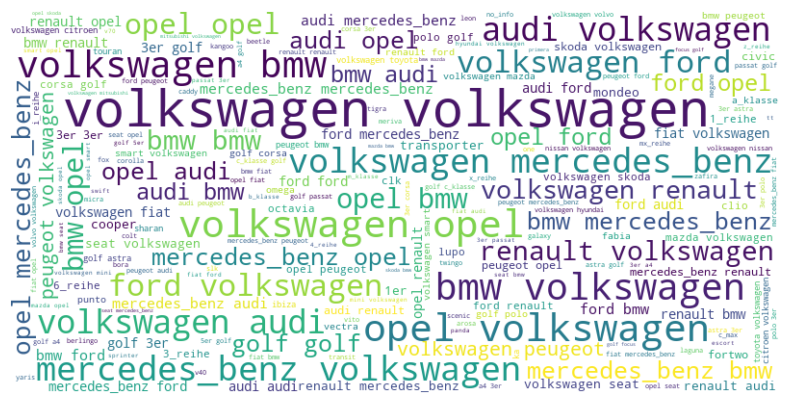

In [41]:
cloud_columns = ['brand', 'model']

# Собираем все значения категориальных признаков в один текст
text = ' '.join(df[col].astype(str).str.cat(sep=' ') for col in cloud_columns)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Отображаем облако слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [42]:
# Проверим датасет на наличие пропущенных значений:

df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
postal_code           0
last_seen             0
dtype: int64

In [43]:
# Проверим датасет на наличие явных дубликатов:

print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 3


In [44]:
df[df.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,petrol,volkswagen,no,2016-03-18,36391,2016-03-18 18:46:15


In [45]:
df = df.drop_duplicates()

In [46]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
postal_code           0
last_seen             0
dtype: int64

In [47]:
df.describe()

,price,registration_year,power,kilometer,registration_month,postal_code
count,262374.000000,262374.000000,262374.000000,262374.000000,262374.000000,262374.000000
mean,4076.244841,2002.578209,114.650133,132736.970889,6.009113,51109.704468
std,3489.131575,6.013279,43.475994,30870.604548,3.576441,25719.192066
min,202.000000,1910.000000,41.000000,30000.000000,0.000000,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,30916.000000
50%,2900.000000,2003.000000,109.000000,150000.000000,6.000000,50170.000000
75%,5999.000000,2007.000000,143.000000,150000.000000,9.000000,71640.000000
max,14599.000000,2016.000000,244.000000,150000.000000,12.000000,99998.000000


In [48]:
# Определим перечень признаков для тепловой карты корреляций

corr_list = ['price',
            'vehicle_type',
            'registration_year',
            'gearbox',
             'power',
             'kilometer',
             'fuel_type',
             'repaired'
            ]

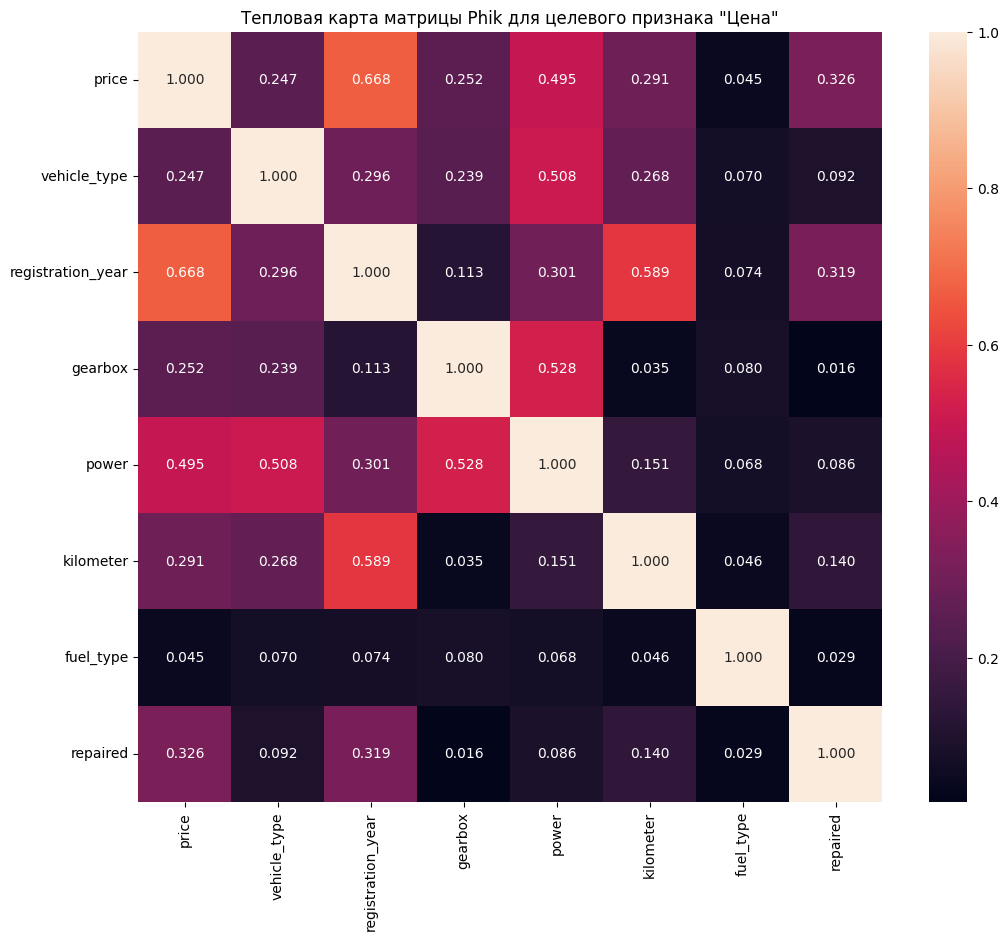

In [49]:
# Построим тепловую карту матрицы Phik для признаков датафрейма:

phik_matrix = df[corr_list].phik_matrix(interval_cols=['price', 'power', 'kilometer'])
plt.figure(figsize=(12,10))
sns.heatmap(phik_matrix, annot=True, fmt='.3f')
plt.title('Тепловая карта матрицы Phik для целевого признака "Цена"', fontsize=12)
plt.show()

Наибольшая корреляция целевого признака (Цена) прослеживается с годом регистрации автомобиля (r = 0.65),  
а также с мощностью двигателя (r = 0.50).  
Взаимная корреляция между остальными признаками слабая и средняя (0.02 < r < 0.56).  

Мультиколлениарности не выявлено.

## Обучение моделей

In [50]:
# Избавимся от признаков, не влияющих на целевой

drop_features = ['date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen']
df = df.drop(drop_features, axis=1)

In [51]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no_info
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [52]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']  
num_features = ['registration_year', 'power', 'kilometer']

### Линейная регрессия

In [53]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                   )
print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

(65594, 9) (65594,) (196780, 9) (196780,)


In [54]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_ohe = encoder.fit_transform(X_train[cat_features])
X_test_ohe = encoder.transform(X_test[cat_features])

encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_features])
X_test_scaled = scaler.transform(X_test[num_features])
    
# Создание тренировочного и тестового датафреймов из закодированных и отмасштабированных данных

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_features)
    
# Объединение всех преобразованных данных в тренировочный и тестовый датафреймы

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
    
# Инициализация и обучение модели на тренировочных данных + таймер

start = time.time() 
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
training_time_l = time.time() - start
print('\u001b[95m','Время обучения = ', round(training_time_l, 4), '\u001b[0m')

# Предсказанные значения для X_test + таймер

start = time.time()   
predictions = model_lr.predict(X_test)
predict_time_l = time.time() - start
print('\u001b[95m','Время предсказания  = ', round(predict_time_l, 3), '\u001b[0m')


C:\Users\zephy\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


 Время обучения =  3.1284 
 Время предсказания  =  0.135 


In [55]:
# RMSE — корень среднеквадратичной ошибки
    
rmse_l = root_mean_squared_error(y_test, predictions);
print(f'RMSE = {rmse_l:.1f}');

RMSE = 2027.4


### CatBoost

In [56]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                   )
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

encoder.fit(X_train[cat_features])

X_train[cat_features] = encoder.transform(X_train[cat_features])

X_test[cat_features] = encoder.transform(X_test[cat_features])

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(196780, 9) (65594, 9)
(196780,) (65594,)


In [57]:
model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[0.3, 0.4, 0.5],
               'random_state':[12345],
               'verbose':[False]}
             ]
gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(X_train, y_train)

print('\u001b[95m', 'Лучшие параметры: ', gscv.best_params_, '\u001b[0m')
print('\u001b[95m', 'Лучшая оценка на кросс-валидации: ', gscv.best_score_, '\u001b[0m')

 Лучшие параметры:  {'learning_rate': 0.4, 'random_state': 12345, 'verbose': False} 
 Лучшая оценка на кросс-валидации:  -1564759.0976519852 


In [58]:
start = time.time()
model_cbr_best = CatBoostRegressor(**gscv.best_params_)
model_cbr_best.fit(X_train, y_train)
training_time_cbr = time.time() - start
print('\u001b[95m','Время обучения = ', round(training_time_cbr, 3), '\u001b[0m')

 Время обучения =  10.501 


In [59]:
start = time.time()
y_pred = model_cbr_best.predict(X_test)
predict_time_cbr = time.time() - start
print('\u001b[95m','Время предсказания  = ', round(predict_time_cbr, 3), '\u001b[0m')

 Время предсказания  =  0.019 


In [60]:
rmse_cbr = root_mean_squared_error(y_test, y_pred)
print('\u001b[95m','RMSE = ', round(rmse_cbr, 2), '\u001b[0m')

 RMSE =  1248.35 


### Light Gradient Boosted Machine (LightGBM)

In [61]:
start = time.time()
model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[800, 850, 900], 'learning_rate':[0.05, 0.1, 0.15], 'random_state':[12345]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

print('\u001b[95m', 'Лучшие параметры: ', clf.best_params_, '\u001b[0m')
print('\u001b[95m', 'Лучшая оценка на кросс-валидации: ', clf.best_score_, '\u001b[0m')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 157424, number of used features: 9
[LightGBM] [Info] Start training from score 4075.834708
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 157424, number of used features: 9
[LightGBM] [Info] Start training from score 4088.679477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [62]:
start = time.time()
model_lgbmr_best = LGBMRegressor(**clf.best_params_)
model_lgbmr_best.fit(X_train, y_train)
training_time_lgbmr = time.time() - start
print('\u001b[95m','Время обучения = ', round(training_time_lgbmr, 3), '\u001b[0m')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 582
[LightGBM] [Info] Number of data points in the train set: 196780, number of used features: 9
[LightGBM] [Info] Start training from score 4084.181533
 Время обучения =  2.785 


In [63]:
start = time.time()
y_pred = model_lgbmr_best.predict(X_test)
predict_time_lgbmr = time.time() - start
print('\u001b[95m','Время предсказания  = ', round(predict_time_lgbmr, 3), '\u001b[0m')

 Время предсказания  =  0.221 


In [64]:
rmse_lgbmr = root_mean_squared_error(y_test, y_pred)
print('\u001b[95m', 'RMSE на тестовой выборке = ', round(rmse_lgbmr, 2), '\u001b[0m')

 RMSE на тестовой выборке =  1222.71 


## Анализ моделей

Определим сравнение изученных моделей введя столбец с рейтингом. Учтем равнозначность параметров по времени обучения модели, времени предсказания модели и RMSE. Введем коэффициенты учитывыающие вес данных зависящий от порядка численного значения.

In [65]:
data = {'Время обучения модели':[training_time_l, training_time_cbr, training_time_lgbmr],
        'Время предсказания модели':[predict_time_l, predict_time_cbr, predict_time_lgbmr],
        'RMSE обучения':[rmse_l, rmse_cbr, rmse_lgbmr]}

index = ['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor',]

data_final = pd.DataFrame(data=data, index=index)

data_final['Рейтинг модели'] = (data_final['Время обучения модели'] * 0.33/10 + data_final['Время предсказания модели'] * 0.33 + data_final['RMSE обучения'] * 0.34/1000)

display(data_final.sort_values(by='Рейтинг модели', ascending=True).style.background_gradient(cmap='Reds', axis=0))

,Время обучения модели,Время предсказания модели,RMSE обучения,Рейтинг модели
LGBMRegressor,2.784639,0.220768,1222.708098,0.580467
CatBoostRegressor,10.501405,0.019360,1248.350617,0.777374
LinearRegression,3.128352,0.134699,2027.447643,0.837019


- У моделей LightGBM и LinearRegression близкий результат по времени обучения модели. Вместе с тем, LightGBM имеет наилучшую метрику RMSE.
- CatBoost на порядок дольше обучается, но время предсказания модели наименьшее среди всех. По величине RMSE незначительно уступает LightGBM.

Модель `LGBMRegressor` оказалась наиболее подходящей исходя из минимального значения метрики RMSE и введенного рейтинга.

# Выводы:

В результате работы над проектом были предприняты следующие шаги:

- Загрузка и ознакомление с данными сервиса по продаже автомобилей с пробегом;
- Выявление пропусков в данных. Для признаков `VehicleType` и `Model`провели заполнение пропусков по самому распространенному значению каждого бренда `Brand`. Пропущенные значения полей `gearbox` и `fuel_type` заполнили на основании модели и бренда (по наиболее распространенному значению); 
- Очистка датасета от аномальных значений в данных, неявных дубликатов;
- Обнаружение дубликатов с последующим их удалением;
- Проведен корреляционный анализ. Средняя (наибольшая) корреляция целевого признака `Цена` прослеживается с годом регистрации автомобиля (r = 0.67), а также с мощностью двигателя (r = 0.50); 
- Созданы три модели с разными гиперпараметрами:
    - модель линейной регрессии `LinearRegression`,
    - `CatBoost` и `LightGBM`, реализованные на градиентном бустинге.
    Все модели соответсвовали показателю `RMSE` < 2500;
- Произведен анализ полученных результатов для выбора лучшей модели по соотношению время/качество, основываясь на обучающей выборке.  

Наиучшей показала себя модель `LGBMRegressor`. На тестовой выборке она показала результат `RMSE` = 1223.